In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import sys
sys.path.append("../../")

In [3]:
# Check Data 
datafile = pd.read_csv("artifacts/DNA-dataset:v0/dataset.csv.gz")
datafile.head()

,Unnamed: 0,chrom,seq,hepg2,k562,sknsh
0,0,chr7,CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...,0.233601,0.060779,0.047194
1,1,chr1,CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...,0.004565,0.379639,-0.244395
2,2,chr1,CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...,0.384537,0.036707,-0.004578
3,3,chr15,CATAAAGGCAGTGTAGACCCAAACAGTGAGCAGTAGCAAGATTTAT...,4.116494,4.508784,3.040183
4,4,chr12,CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...,1.423444,1.616602,1.335892


In [5]:
import wandb

run = wandb.init()
artifact = run.use_artifact('fderc_diffusion/Diffusion-DNA-RNA/DNA-model:v0')
dir = artifact.download()
wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sarosavo. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact DNA-model:v0, 1318.41MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:14.6


In [6]:
# Select data 
small_data = datafile.loc[ (datafile['chrom'] =="chr1") | (datafile['chrom'] =="chr2") |(datafile['chrom'] =="chr3") |(datafile['chrom'] =="chr4")  ]

In [7]:
from src.utils.sequence import seqs_to_one_hot

seq_x = [seqs_to_one_hot(seq)[:, 0, :] for seq in small_data['seq']]
small_data_x = np.array(seq_x)
print(small_data_x.shape) # Data Size 

(203842, 200, 4)


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 3.000e+00,
        1.000e+00, 2.000e+00, 2.000e+0

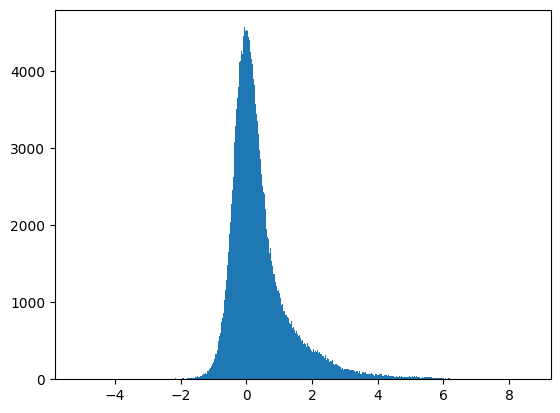

In [8]:
hepg2_scores = np.array(small_data['hepg2'])

import matplotlib.pyplot as plt
plt.hist(hepg2_scores, bins = 'auto')

In [9]:
from grelu.lightning import LightningModel
DEVICE = "cuda:1"

model = LightningModel.load_from_checkpoint("artifacts/DNA-model:v0/reward_model.ckpt")
model.eval()
model.to(DEVICE)

/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/yulai/anaconda3/envs/grelu/lib/python3.9/site-packages/enformer_pytorch/modeling_enformer.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch

LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [10]:
import torch

data_loader = torch.utils.data.DataLoader(small_data_x.astype("float32"), batch_size = 128 , num_workers=0)
relabel_y = []

for batch in data_loader:
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    relabel_y.append( model(batch).detach().cpu() ) 

relabel_y = np.concatenate(relabel_y)

In [11]:
relabel_y.shape

(203842, 3, 1)

In [12]:
hepg2_relabel_y = relabel_y[:,0].reshape(-1)
k562_relabel_y = relabel_y[:,1].reshape(-1)

print(hepg2_relabel_y.shape)

(203842,)


(array([1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 4.000e+00,
        6.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 3.000e+0

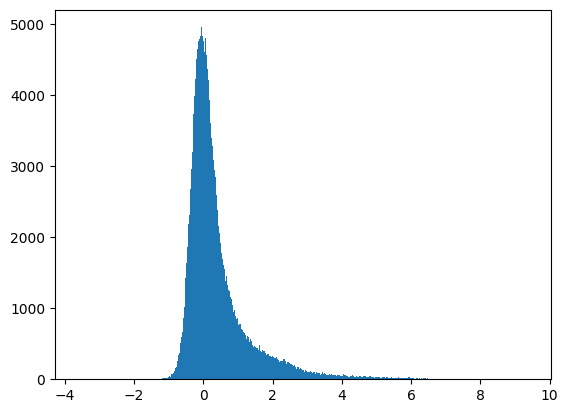

In [13]:
plt.hist(hepg2_relabel_y, bins = 'auto')

[-0.35024275 -0.20659633 -0.09449214  0.01328751  0.12747552  0.26613297
  0.46187972  0.80856459  1.58383113]
(203842,)


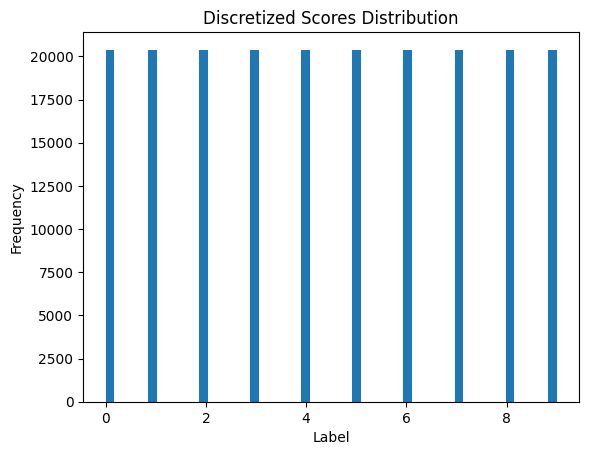

In [19]:
quantiles = np.quantile(hepg2_relabel_y, np.arange(0.1, 1.0, 0.1))

hepg2_relabel_y_list = hepg2_relabel_y.tolist()

print(quantiles)
discretized_indices = []

for idx, score in enumerate(hepg2_relabel_y_list):
    label = 0
    for q_idx, q_value in enumerate(quantiles):
        if score < q_value:
            break
        label = q_idx + 1
    discretized_indices.append(label)

discretized_indices = np.array(discretized_indices)
print(discretized_indices.shape)

# Plot the histogram of the discretized indices
plt.hist(discretized_indices, bins='auto')
plt.title('Discretized Scores Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

# Save offline data for training

In [20]:
# np.savez_compressed("./artifacts/MPRA-dataset:v2/y_HepG2_relabel.npz", x = small_data_x, y = hepg2_relabel_y)

np.savez_compressed("./artifacts/DNA-dataset:v0/y_HepG2_10class.npz", x = small_data_x, y = discretized_indices)